## TDA for digit classification on MNIST data set 

# A. Images as cubical complexes

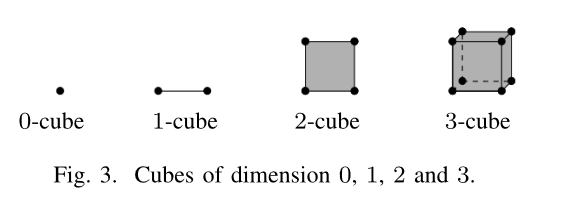

A d-dimensional image is a map I : S ⊆ Zd −→ R. An
element v ∈ S is called a voxel (or pixel when d = 2) and
the value I(v) is called its intensity or greyscale value.

In [60]:
import pandas as pd
import numpy as np

# Load data and split into training and testing sets
mnist = pd.read_csv('train.csv')
labels = np.array(mnist[mnist.columns[0]])
mnist = np.array(mnist[mnist.columns[1::]])

from sklearn.model_selection import train_test_split

train_size, test_size = 6000, 1000

# Reshape to (n_samples, n_pixels_x, n_pixels_y)
mnist = mnist.reshape((-1, 28, 28))

X_train, X_test, y_train, y_test = train_test_split(
    mnist, labels, train_size=train_size, test_size=test_size, stratify=labels, random_state=666
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (6000, 28, 28), y_train shape: (6000,)
X_test shape: (1000, 28, 28), y_test shape: (1000,)


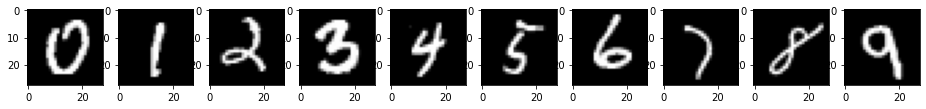

In [61]:
from PIL import Image as im
import matplotlib.pyplot as plt
# Take a random example from each digit
sample_i = np.empty(10, dtype=int)
for k in range(0,10):
    # (1) indices of all the points from X that belong to cluster i
    C_i = np.where(y_train == k)[0].tolist() 
    # (2) indices of the points to be sampled from cluster i
    sample_i[k] = np.random.choice(C_i, 1)
    
# Display examples
fig = plt.figure(figsize = (16, 20))
for i in range(0,10):
    array = X_train[sample_i[i],:]
    array = np.reshape(array, (28, 28))
    image = im.fromarray(np.uint8(array))

    fig.add_subplot(1, 10, i+1)
    imgplot = plt.imshow(image, cmap='gray')


# B. Filtrations

# Binarization:
Starting from a grayscale image, we use the voxel values directly as a filtration. To be able to make use of the binary filtrations described previously, we binarize the image according to a pixel value threshold of 40%

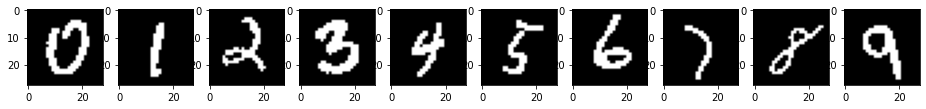

In [62]:
from gtda.images import Binarizer

# Pixels with values less than 0.4 become 0
binarizer = Binarizer(threshold=0.4)
im_binarized = binarizer.fit_transform(X_train)

#display
fig2 = plt.figure(figsize = (16, 20))
for i in range(0,10):
    array = im_binarized[sample_i[i],:]
    image = im.fromarray(np.uint8(array))
    fig2.add_subplot(1, 10, i+1)
    imgplot = plt.imshow(image, cmap='gray')

# Radial Filtration:


In [69]:
from gtda.images import RadialFiltration

radial_filtration = RadialFiltration(center=np.array([14, 14]))
im_filtration = radial_filtration.fit_transform(im_binarized)

radial_filtration.plot(im_filtration[0][None, :, :], colorscale="jet")

# Height Filtration:
For cubical complexes, we define the height filtration
H : I −→ R of a d-dimensional binary image I by choosing
a direction v ∈ Rd of norm 1 and defining new values on
all the voxels of value 1 as follows: if p ∈ I is such that
B(p) = 1, then one assigns a new value H(p) :=< p, v >,
the distance of p to the hyperplane defined by v. If B(p) = 0,
then H(p) := H∞, where H∞ is the filtration value of the
pixel that is the farthest away from the hyperplane.
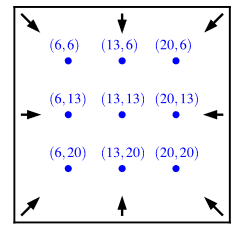

In [117]:
from gtda.homology import CubicalPersistence
from gtda.diagrams import Scaler

#calculate persistence
cubical_persistence = CubicalPersistence(n_jobs=-1)
im_cubical = cubical_persistence.fit_transform(im_filtration)
#scale down for visualization purposes
scaler = Scaler()
im_scaled = scaler.fit_transform(im_cubical)
cubical_persistence.plot(im_scaled[0][None,:,:])

# Making a pipeline

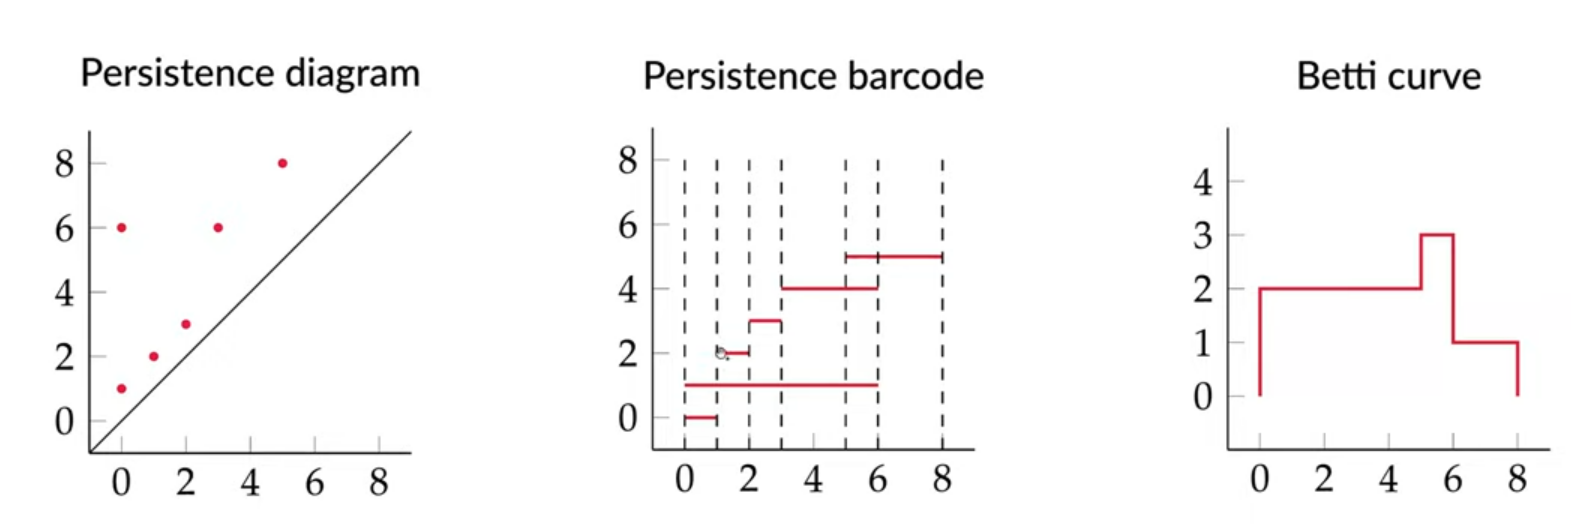

In [65]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

In [66]:
from sklearn import set_config
set_config(display='diagram')

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 Persist...
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-11',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-12',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-13',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1))]))]))])

In [67]:
X_train_tda = tda_union.fit_transform(X_train)
X_train_tda.shape

(6000, 476)

# Turning the transformed data into classifications

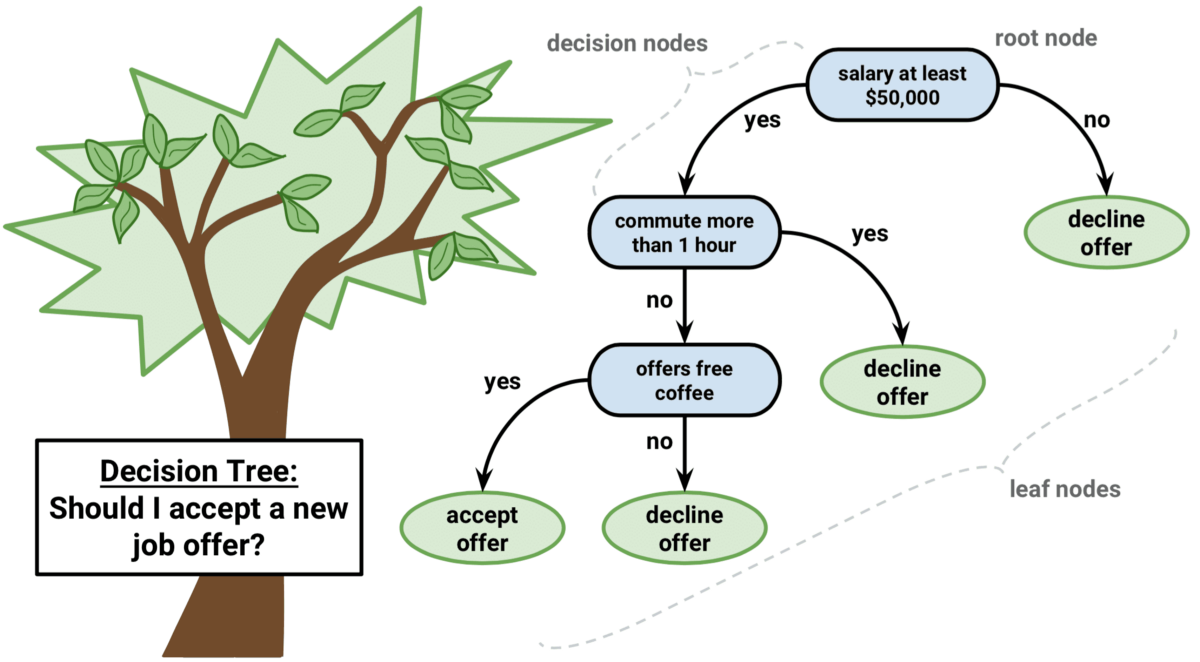

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

X_test_tda = tda_union.transform(X_test)
rf.score(X_test_tda, y_test)

0.949

In [104]:
from sklearn.metrics import confusion_matrix,accuracy_score
pred = rf.predict(X_test_tda)
cm = confusion_matrix(y_test, pred)

print(cm)

[[ 96   0   1   0   0   0   0   0   1   0]
 [  0 110   0   0   0   0   0   2   0   0]
 [  0   0  94   1   0   2   1   1   0   0]
 [  0   0   0 103   0   1   0   0   0   0]
 [  0   0   0   0  92   1   1   0   0   3]
 [  0   0   2   0   0  85   1   0   2   0]
 [  0   0   0   0   0   0  97   0   1   0]
 [  0   0   9   2   0   1   0  91   0   2]
 [  0   0   0   0   0   3   3   0  89   2]
 [  1   1   0   1   3   0   0   2   0  92]]


In [110]:
fivestest = np.where(y_test == 5)
fivespred = np.where(pred == 5)
difference_1 = np.setdiff1d(fivespred,fivestest)
common = np.intersect1d(difference_1, np.where(y_test == 8))

print(common)

[ 99 118 692]


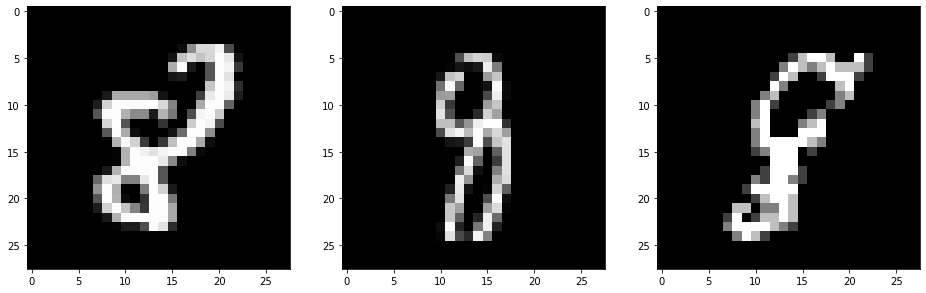

In [113]:
# Display examples
fig = plt.figure(figsize = (16, 20))
for i in range(0,3):
    array = X_test[common[i],:]
    array = np.reshape(array, (28, 28))
    image = im.fromarray(np.uint8(array))

    fig.add_subplot(1,3, i+1)
    imgplot = plt.imshow(image, cmap='gray')


Examples of 8 digit being misclassified by my model